In [ ]:
!git clone https://github.com/stefan-matcovici/language-detection.git
!pip install -r language-detection/requirements.txt

In [1]:
import sys
sys.path.append('/content/language-detection/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pycld2 as cld2
import langid
from iso639 import languages

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from operator import itemgetter

from data.willi2018 import Wili2018Dataset

###Select subset of languages from all 3 libraries

In [4]:
cld2_languages = set(list(map(itemgetter(1), cld2.LANGUAGES)))
langdetect_languages = ["af", "ar", "bg", "bn", "ca", "cs", "cy", "da", "de", "el", "en", "es", "et", "fa", "fi", "fr", "gu", "he",
"hi", "hr", "hu", "id", "it", "ja", "kn", "ko", "lt", "lv", "mk", "ml", "mr", "ne", "nl", "no", "pa", "pl",
"pt", "ro", "ru", "sk", "sl", "so", "sq", "sv", "sw", "ta", "te", "th", "tl", "tr", "uk", "ur", "vi", "zh-cn", "zh-tw"]
langid_languages = ["af", "am", "an", "ar", "as", "az", "be", "bg", "bn", "br", "bs", "ca", "cs", "cy", "da", "de", "dz", 
                    "el", "en", "eo", "es", "et", "eu", "fa", "fi", "fo", "fr", "ga", "gl", "gu", "he", "hi", "hr", "ht", "hu", "hy", 
                    "id", "is", "it", "ja", "jv", "ka", "kk", "km", "kn", "ko", "ku", "ky", "la", "lb", "lo", "lt", "lv", "mg", "mk", 
                    "ml", "mn", "mr", "ms", "mt", "nb", "ne", "nl", "nn", "no", "oc", "or", "pa", "pl", "ps", "pt", "qu", "ro", "ru", 
                    "rw", "se", "si", "sk", "sl", "sq", "sr", "sv", "sw", 
                    "ta", "te", "th", "tl", "tr", "ug", "uk", "ur", "vi", "vo", "wa", "xh", "zh", "zu"]
common_languages = set(cld2_languages) & set(langid_languages) & set(langdetect_languages)
common_languages = [languages.get(alpha2=x).part3.lower() for x in common_languages]

In [5]:
target_languages = ['eng', 'rus', 'fra', 'spa', 'deu', 'ita', 'nld', 'jpn', 'ara', 'hin', 'urd', 'por', 'fas', 'kor', 'est', 'ron', 'swe', 'tha']

In [6]:
assert len([lang for lang in target_languages if lang not in common_languages]) == 0

###Download and load dataset

In [7]:
!cd language-detection; chmod u+x scripts/download_wili2018.sh; ./scripts/download_wili2018.sh

In [8]:
wili2018 = Wili2018Dataset(target_languages)
X_train, Y_train, X_test, Y_test = wili2018.get_data()

###CLD2
---
**Compact Language Detector 2** (CLD2) uses a **Naïve Bayes** classifier with different token algorithms.

In [9]:
y_pred = []
for txt in tqdm(X_test):
    try:
        normalized_text = txt.encode('utf8')
        detected_language_alpha_2 = cld2.detect(normalized_text)[2][0][1]
        detected_language_alpha_3 = languages.get(alpha2=detected_language_alpha_2).part3.lower()
        if detected_language_alpha_3 not in target_languages:
            y_pred.append('unk')
        else:
            y_pred.append(detected_language_alpha_3)
    except:
       y_pred.append('unk')

####Classification report

In [10]:
print(classification_report(Y_test, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

         ara     1.0000    0.9940    0.9970       500
         deu     0.9938    0.9640    0.9787       500
         eng     0.7845    0.9900    0.8753       500
         est     1.0000    0.9520    0.9754       500
         fas     0.9980    0.9980    0.9980       500
         fra     0.9659    0.9640    0.9650       500
         hin     1.0000    0.9760    0.9879       500
         ita     0.9935    0.9240    0.9575       500
         jpn     1.0000    0.9940    0.9970       500
         kor     1.0000    0.9900    0.9950       500
         nld     1.0000    0.9600    0.9796       500
         por     0.9956    0.9100    0.9509       500
         ron     1.0000    0.9560    0.9775       500
         rus     0.9978    0.8920    0.9419       500
         spa     0.9957    0.9220    0.9574       500
         swe     1.0000    0.9540    0.9765       500
         tha     1.0000    0.9880    0.9940       500
         unk     0.0000    

####Confusion matrix

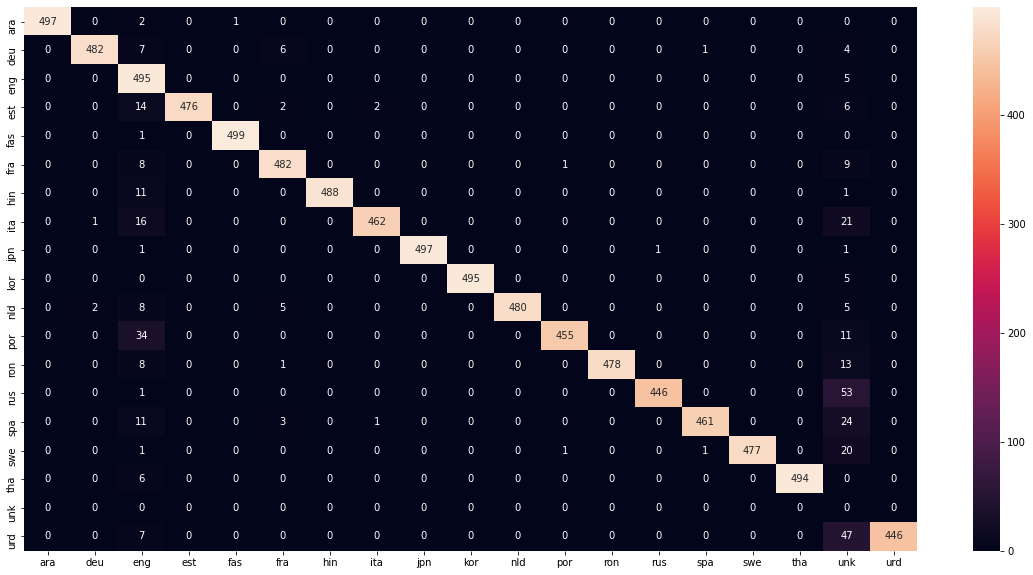

In [11]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(Y_test, y_pred, labels=label_list)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list)

###langid
---
**Langid** uses **LD feature selection** and a **Naïve Bayes** classifier.

In [12]:
y_pred = []
for txt in tqdm(X_test):
    detected_language_alpha_2 = langid.classify(txt)
    detected_language_alpha_3 = languages.get(alpha2=detected_language_alpha_2[0]).part3.lower()

    if detected_language_alpha_3 not in target_languages:
        y_pred.append('unk')
    else:
        y_pred.append(detected_language_alpha_3)

####Classification report

In [13]:
print(classification_report(Y_test, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

         ara     0.9288    0.9920    0.9594       500
         deu     0.9838    0.9700    0.9768       500
         eng     0.8496    0.9940    0.9161       500
         est     1.0000    0.9280    0.9627       500
         fas     0.9901    0.9980    0.9940       500
         fra     0.9688    0.9920    0.9802       500
         hin     1.0000    0.9540    0.9765       500
         ita     0.9917    0.9540    0.9725       500
         jpn     1.0000    0.9940    0.9970       500
         kor     1.0000    0.9900    0.9950       500
         nld     1.0000    0.9780    0.9889       500
         por     0.9978    0.9280    0.9617       500
         ron     1.0000    0.9760    0.9879       500
         rus     0.9862    0.9980    0.9920       500
         spa     0.9980    0.9740    0.9858       500
         swe     0.9980    0.9960    0.9970       500
         tha     1.0000    0.9880    0.9940       500
         unk     0.0000    

####Confusion matrix

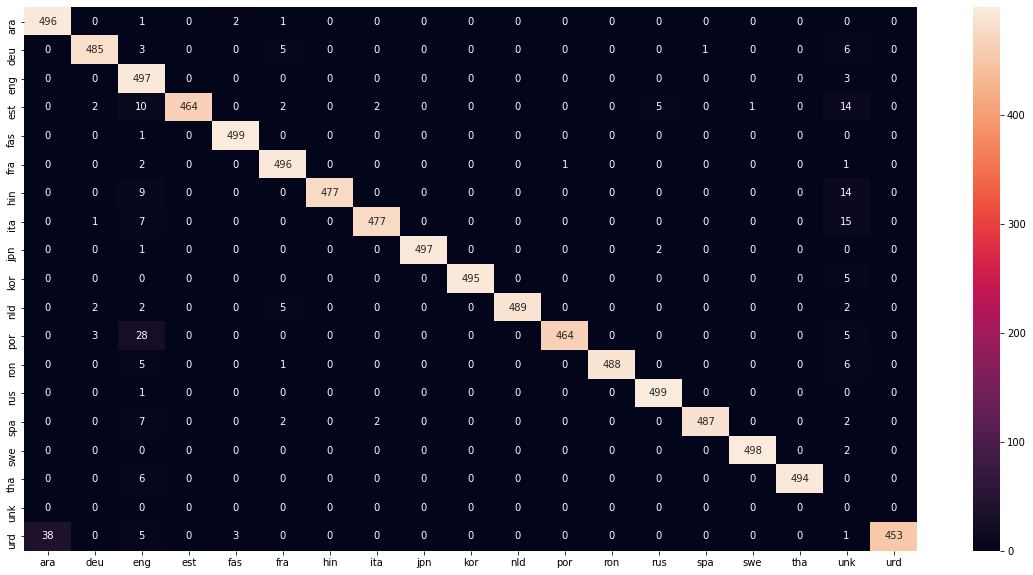

In [14]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(Y_test, y_pred, labels=label_list)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list)

###Langdetect
---
**Langdetect** uses character n-gram features, **Naïve Bayes** classifier, noise filter and character normalization

In [15]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [16]:
y_pred = []
for txt in tqdm(X_test):
    try:
        detected_language_alpha_2 = detect(txt)
        detected_language_alpha_3 = languages.get(alpha2=detected_language_alpha_2).part3.lower()

        if detected_language_alpha_3 not in target_languages:
            y_pred.append('unk')
        else:
            y_pred.append(detected_language_alpha_3)
    except:
        y_pred.append('unk')

####Classification report

In [17]:
print(classification_report(Y_test, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

         ara     0.9171    0.9960    0.9549       500
         deu     0.9839    0.9760    0.9799       500
         eng     0.8218    0.9960    0.9005       500
         est     0.9979    0.9600    0.9786       500
         fas     1.0000    0.9980    0.9990       500
         fra     0.9650    0.9940    0.9793       500
         hin     1.0000    0.9760    0.9879       500
         ita     0.9916    0.9480    0.9693       500
         jpn     1.0000    0.9900    0.9950       500
         kor     1.0000    0.9880    0.9940       500
         nld     1.0000    0.9760    0.9879       500
         por     0.9979    0.9320    0.9638       500
         ron     1.0000    0.9860    0.9930       500
         rus     0.9920    0.9960    0.9940       500
         spa     0.9959    0.9720    0.9838       500
         swe     1.0000    1.0000    1.0000       500
         tha     1.0000    0.9880    0.9940       500
         unk     0.0000    

####Confusion matrix

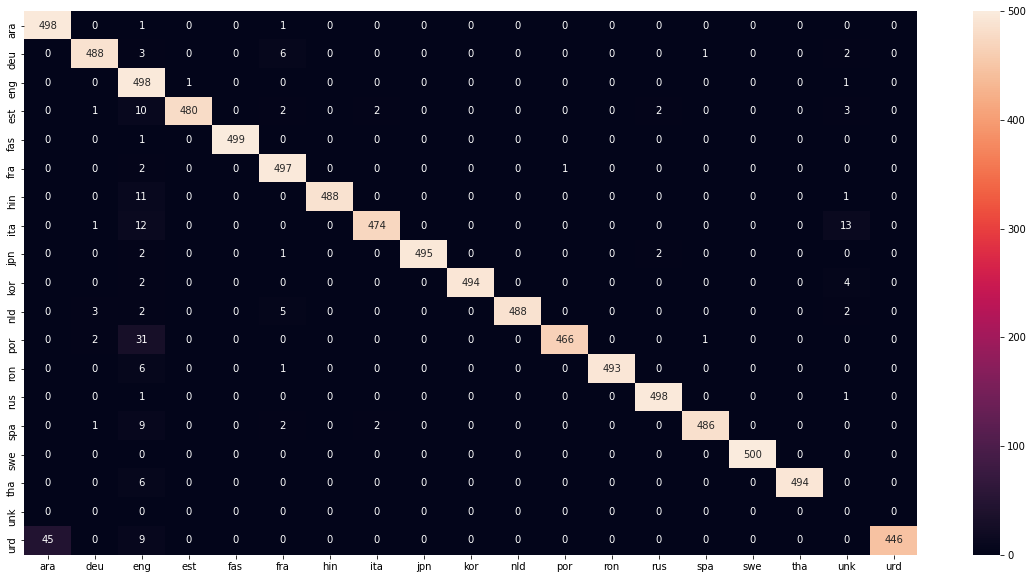

In [18]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(Y_test, y_pred, labels=label_list)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list)